# wrap into py

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/MyDrive/bio_simCLR')
%load_ext autoreload
%autoreload 2

%ls /content/gdrive/MyDrive/bio_simCLR

Mounted at /content/gdrive/
'Biologically inspired data augmentation for self supervised learning.gslides'
 deepgaze_scanpath.py
 run_magnif_mod.py
 scanpaths.tar.bz
 stl10_binary.tar.gz
 stl10_unlabeled_salmaps_salicon.npy
 stl10_unlabeled_scanpath_deepgaze.npy


In [ ]:
# !python /content/gdrive/MyDrive/bio_simCLR/deepgaze_scanpath.py --parallel_id 5

# combine to large npy

In [2]:
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!tar -xvzf /content/gdrive/MyDrive/bio_simCLR/scanpaths.tar.bz

Streaming output truncated to the last 5000 lines.
scanpaths/stl10_unlabeled_scanpath_deepgaze_9203.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_7289.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_75998.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_13058.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_24647.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_85159.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_16233.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_17889.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_79909.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_56615.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_31506.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_69436.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_55017.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_1920.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_75564.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_42448.npy
scanpaths/stl10_unlabeled_scanpath_deepgaze_53620.npy
scanpaths/stl10_unlabeled_scanpath

In [61]:
%cd /content/scanpaths/

npy_files = glob.glob("*.npy")

dataset_len = 100000
nfix_total = 20
scanpath_arr = scanpath_arr = np.zeros((dataset_len, nfix_total, 2)) # n img, n fix per img, x & y

for i in tqdm(range(dataset_len)):
  scanpath_filename = f'stl10_unlabeled_scanpath_deepgaze_{i}.npy'
  try:
    scanpath_single = np.load(scanpath_filename)
    scanpath_arr[i,:,:] = scanpath_single
  except:
    # print('not exist')
    continue
  
# 89%|████████▉ | 88778/100000 [00:33<00:03, 2995.02it/s] 
# then not exist

/content/scanpaths


100%|██████████| 100000/100000 [00:27<00:00, 3616.44it/s]


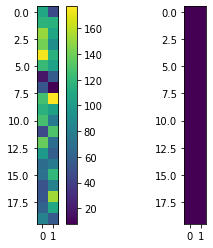

In [62]:
plt.subplot(1,2,1)
plt.imshow(scanpath_arr[88126, :, :]);
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(scanpath_arr[88127, :, :]); # all zeros from 88127 onwards (included)

In [63]:
scanpath_arr = np.floor(scanpath_arr / 255 * 95)

In [88]:
# inhibition of return

# `cover_ratio` control area of sampling relative to the full image size. 
# It's approximately the ratio of image area under sampling grid and full image size.

img_side = 96
sampling_bdr = 16 # current run_magnif.py uses bdr = 16 pixel
cover_ratio = 0.35 # current run_magnif.py uses cvr = 0.05~0.35
side_ratio = np.sqrt(0.35)
sample_side = side_ratio * img_side # orig img = 96 x 96 pixel
distance_min = sample_side / 3 # ensure overlap < some percentage of sample size

sample_side, distance_min

(56.79436591775631, 18.93145530591877)

In [89]:
legit_nfix = []
for i in tqdm(range(dataset_len)): # dataset_len
    scanpath_img = scanpath_arr[i, :, :]
    scanpath_img_legit = [[0,0]] # legit sampling center points
    for ifix in range(nfix_total):

        if (scanpath_img[ifix, 0] < sampling_bdr) or (scanpath_img[ifix, 0] > img_side-sampling_bdr) \
        or (scanpath_img[ifix, 1] < sampling_bdr) or (scanpath_img[ifix, 1] > img_side-sampling_bdr):
            scanpath_img[ifix, 0] = 0 # out of border fixation, set to 0
            scanpath_img[ifix, 1] = 0
            # print(scanpath_img[ifix, :], 'set to 0')

        if scanpath_img[ifix, 0] != 0: # not out of border
            distance_ifix = [np.sqrt((scanpath_img[ifix, 0] - pnt[0])**2 + (scanpath_img[ifix, 1] - pnt[1])**2) for pnt in scanpath_img_legit]
            if np.all(np.array(distance_ifix) >= distance_min):
                # print(distance_ifix)
                scanpath_img_legit.append(scanpath_img[ifix, :])
            else:
                scanpath_img[ifix, 0] = 0 # not far enough from legit fixation points, set to 0
                scanpath_img[ifix, 1] = 0
    # print(len(scanpath_img_legit))
    legit_nfix.append(len(scanpath_img_legit))

100%|██████████| 100000/100000 [00:12<00:00, 8286.04it/s]


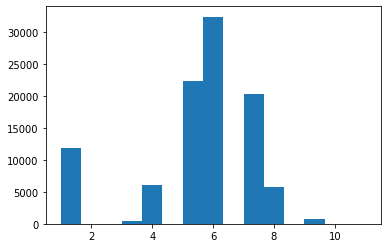

In [90]:
plt.hist(legit_nfix, bins=15);

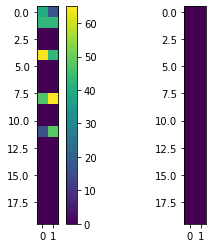

In [91]:
plt.subplot(1,2,1)
plt.imshow(scanpath_arr[88126, :, :]);
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(scanpath_arr[88127, :, :]); # all zeros from 88127 onwards (included)

In [ ]:
# scanpath_arr = np.floor(scanpath_arr / 95 * 255) # updated dataset_w_salmap.py. not needed here

In [92]:
np.save("/content/gdrive/MyDrive/bio_simCLR/stl10_unlabeled_scanpath_deepgaze_inh_return.npy", scanpath_arr)